In [1]:
import pandas as pd

In [32]:
from ipyfilechooser import FileChooser
from IPython.display import display
# Create a file chooser
fc = FileChooser('D:\\code\\uom_explore\\raw_data')
display(fc)

column_names = ['Setting', 'Timestamp', 'ADC']


# Button to load the selected file
def load_data(b):
    global df
    data_path = fc.selected
    if data_path:
        df = pd.read_csv(data_path, sep=',', header=None, names=column_names, usecols=column_names)
        display(df.head())

fc.register_callback(load_data)
# click on the output and use Alt+delete to clear and choose again

FileChooser(path='D:\code\uom_explore\raw_data', filename='', title='', show_hidden=False, select_desc='Select…

,Setting,Timestamp,ADC
0,232,52087317,26262
1,235,52087318,26258
2,237,52087319,26256
3,240,52087320,26259
4,242,52087321,26263


In [33]:
import matplotlib.pyplot as plt

# Group the data by 'Setting' without including the grouping columns in the operation
grouped = df.groupby('Setting', as_index=False, group_keys=False)  # Keep 'Setting' as a column, not as an index

# Normalize the timestamps in each group
def normalize_timestamps(group):
    group['Timestamp'] = group['Timestamp'] - group['Timestamp'].iloc[0]
    return group

# Apply the normalization function to each group
df_normalized = grouped.apply(normalize_timestamps).reset_index(drop=True)

# Group the normalized DataFrame again for plotting
grouped_normalized = df_normalized.groupby('Setting')

grouped.size()


C:\Users\gavin\AppData\Local\Temp\ipykernel_29340\1250510539.py:12: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,Setting,size
0,140,741
1,150,741
2,152,741
3,155,741
4,157,741
5,160,741
6,162,741
7,165,741
8,167,741
9,170,741


C:\Users\gavin\AppData\Local\Temp\ipykernel_29340\2895500631.py:16: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



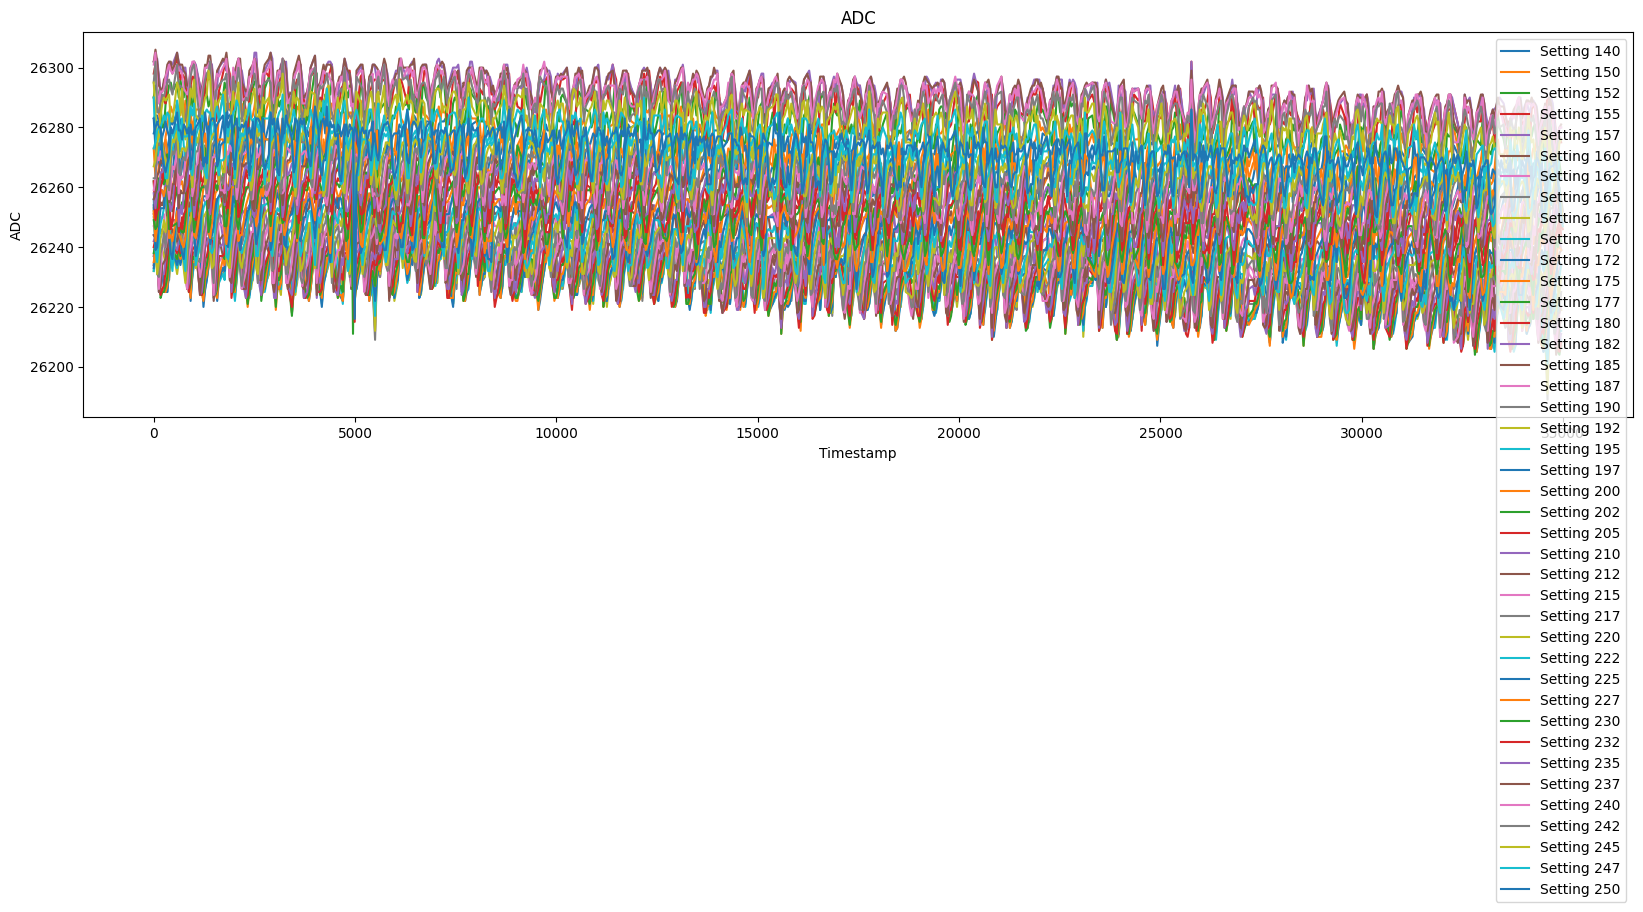

In [34]:
# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(20, 5))

# Set the title for the subplot
ax.set_title('ADC')

# Plotting the ADC channel
for name, group in grouped_normalized:
    ax.plot(group['Timestamp'], group['ADC'], label=f'Setting {name}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('ADC')

# Add legend and adjust layout
ax.legend()

plt.tight_layout()
plt.show()

In [35]:
# use plotly to explore the data interactively
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from scipy.signal import butter, filtfilt

# Filter requirements.
order = 6
fs = 30.0  # sample rate, Hz
cutoff = 3.66  # desired cutoff frequency of the filter, Hz
window_size = 30
group_channel = 'ADC'

# apply low pass filter to each group
def apply_filter(group, order, fs, cutoff, group_channel, window_size):
    # Get the filter coefficients
    b, a = butter(order, cutoff / (fs / 2), btype='low', analog=False)
    group['ADC_filtered'] = filtfilt(b, a, group[group_channel])
    group['ADC_filtered'] = group['ADC_filtered'].rolling(window_size, center=True).median()
    return group


# Apply the filter to each group
df_normalized = grouped_normalized.apply(apply_filter, order=order, fs=fs, cutoff=cutoff, group_channel=group_channel, window_size=window_size).reset_index(drop=True)
input_voltage = 3.3
RL_2 = 10000 # 10kOhm

# convert to resistance where R_laod is R2 = 10kOhm input_voltage = 3.3V and 1_bit = 0.125mV (3.3V/2^14)
df_normalized['Vo'] = df_normalized['ADC_filtered']*0.000125
df_normalized['Resistance'] = (RL_2/df_normalized['Vo'])*((input_voltage/df_normalized['Vo'])-1)


# Define the figure without subplots as we are plotting only one channel
fig = go.Figure()

# The channel to plot
channel = 'Resistance' 
# 'ADC_filtered'

# Plot the channel
for setting in df_normalized['Setting'].unique():
    # Filter the DataFrame for each setting
    df_filtered = df_normalized[df_normalized['Setting'] == setting]
    fig.add_trace(
        go.Scatter(
            x=df_filtered['Timestamp'],
            y=df_filtered[channel],
            mode='lines',
            name=f'Setting {setting}',
            # Optionally, you can uncomment and adjust the line color settings if needed
            # line=dict(color=colors[setting % len(colors)])  # Loop through colors cyclically
        )
    )

# Set titles and axes labels
fig.update_xaxes(title_text='Timestamp')
fig.update_yaxes(title_text=channel)
fig.update_layout(height=500, width=800, title_text=f'{channel} vs. Timestamp', showlegend=True)

# Display figure
fig.show()

C:\Users\gavin\AppData\Local\Temp\ipykernel_29340\937206157.py:24: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



# Examine filter effect

In [ ]:
!pip install statsmodels

In [25]:
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from statsmodels.tsa.filters.hp_filter import hpfilter

# Define the filter
def low_pass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Apply the filter
cutoff = 0.15  # desired cutoff frequency of the filter, Hz
fs = 50.0  # sample rate, Hz
order = 2  # sin wave can be approx represented as quadratic
filtered_data = low_pass_filter(df['ADC'], cutoff, fs, order)

# Define the window size for the moving average
window_size = 150

# Apply the moving average filter to the 'ADC' column
df_normalized['ADC_low_pass'] = low_pass_filter(df['ADC'], cutoff, fs, order) 
df_normalized['ADC_filtered'] = df_normalized['ADC_low_pass'].rolling(window_size).median()


# The specific setting to plot
specific_setting = 192  # Change this to the setting you want to plot

# Filter the DataFrame for the specific setting
df_filtered = df_normalized[df_normalized['Setting'] == specific_setting]

# Define the figure
fig = go.Figure()

# Plot the specific setting
fig.add_trace(
    go.Scatter(
        x=df_filtered['Timestamp'],
        y=df_filtered['ADC_filtered'],
        mode='lines',
        name=f'Setting {specific_setting}',
        # Optionally, you can uncomment and adjust the line color settings if needed
        # line=dict(color=colors[setting % len(colors)])  # Loop through colors cyclically
    )
)

# Set titles and axes labels
fig.update_xaxes(title_text='Timestamp')
fig.update_yaxes(title_text='ADC_filtered')
fig.update_layout(height=500, width=800, title_text=f'ADC_filtered vs. Timestamp for Setting {specific_setting}', showlegend=True)

# Show the plot
fig.show()
